## Dev Dashboarding ##
panel serve PHNX_prod_analytics.ipynb --session-token-expiration 600
* https://docs.google.com/document/d/1PU1OUlR6i1fGRnLsv8iYXmmY_byGu2kccWzCMyY922o/edit

In [39]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import panel as pn
import pickle
import numpy as np

cwd = os.getcwd()
slash_idx = [i for i,l in enumerate(cwd) if l=='/']
repo_dir = cwd[:slash_idx[-1]]
if repo_dir not in sys.path: sys.path.append(repo_dir)

from analysis_pipeline.analysis_pipeline import AnalysisPipeline
from analytics_utils.lims_tools.lims_utils import get_plate_runs, plates_from_exp, plates_from_workflow
from analytics_utils.database_access.s3_interface import download_from_s3, upload_to_s3, s3_imgupload, s3_imgdownload, s3_df2csv, s3_csv2df
from analytics_utils.database_access.table_properties import * 
from analytics_utils.visualization_tools.visualization_utils import plot_boxplot

s3_bucket = 'ml-analytics-file-store' 
dataset_folder = '../../../DATASETS/'
figure_folder = '../../../FIGURES/'
pn.extension(sizing_mode="stretch_width")

overall_analytics_panel = []
variant_analytics_panel = []
top_variant_reps = []
top_variant_analytics_panel = []
activity_corr_panel = []
activityCV_corr_panel = []
plate_analytics_panel = []
library_analytics_panel = []
unit_analytics_panel = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data from table

In [40]:
s3_subfolder = 'VQ-IPTGexp/' # 'VQ-IPTGexp-outliersremoved/' 
exp_workflow = ['WF10203']
table = 'lcms_detections' # 'combi_analytics_table' # 
metric_dict = {'LcmsC18':['pellet_OD', 'measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)']}
# metric_dict = {'LcmsC18':['measured_nonbinary_sum_(r)','measured_nonbinary_score_(r)', 'measured_conversion_(r)'], 'LcmsChiral':['measured_enantiomeric_excess_(+over-)']}
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    metric_dict=metric_dict, 
    get_dashboard_panel=False,
    save_plots_to_s3=True,
    hit_filter_dict = {'measured_nonbinary_score_(r)': 5}
)
df = analysis_pipeline.load_data(table, exp_workflow=exp_workflow)

if table == 'lcms_detections':
    df = analysis_pipeline.get_derived_metrics(df, derived_metrics_to_get=['LcmsC18'])
    df = analysis_pipeline.standardize_dataset_columns(df, data_type=table, update_analytics_table=True)

# save full table to S3
csv_fname = f'{table}_{"-".join(exp_workflow)}'
analysis_pipeline.save_content_to_s3(csv_fname, df, file_format='csv', content_header='FULL DATASET', content_type='dataframe')

executing query: SELECT "id", "address", "run", "plate", "dev_or_prod", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "hamming", "mutations", "reference_enzyme", "enzyme_concentration", "enzyme_unit", "enzyme_class", "sequence_qc", "sample_position", "sample_type", "substrate_barcode", "substrate_concentration", "substrate_unit", "substrate_smiles", "substrate_mz", "product_smiles", "product_mz", "sub_area", "prod_area", "ptr_lcms", "sub_conc_lcms_actual", "prod_conc_lcms_actual", "sum_conc_lcms_actual", "dilution_factor", "injector_volume", "expected_concentration", "concentration_units", "source_plate", "source_address", "seed_address", "seed_address_alphanumeric", "seed_plate", "main_plate", "rxn_plate", "library_barcode", "library_ref", "library_description", "seed_plate_time", "main_plate_time", "rxn_plate_time", "plate_time", "pellet_OD", "pellet_detected", "pellet_area", "pellet_intensity", "

## Data Cleanup + Update exp_condition labels on data

In [25]:
include_only_exp_ctrls = False
change_expcondition_labels_to_uppercase = False
remove_space_from_expcondition_labels = True
add_subconc_to_expcondition_labels = False
add_enzbarcode_to_expcondition_labels = True
add_plate_to_expcondition_labels = False
add_enzbarcode_to_plate_labels = False
clean_up_enzbarcode_labels = False
clean_up_mutstr_labels = False
update_ctrl_label = True

if include_only_exp_ctrls:
    # include only 'exp' type samples 
    df = df.loc[df.ctrl_type=='exp'].copy()

if change_expcondition_labels_to_uppercase:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).upper() for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list
    print(set(df.exp_condition))
    
if remove_space_from_expcondition_labels:
    # clean up exp_condition labels
    exp_condition_list = df.exp_condition.tolist()
    exp_condition_list = [str(e).replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_list
    print(set(df.exp_condition))

if add_subconc_to_expcondition_labels:
    # add substrate concentration to exp_condition labels
    sub_conc_list = [f'{str(int(sub_conc))}mM' for sub_conc in df['substrate_concentration_(r)'].tolist()]
    exp_condition_list = [f'{sub_conc}_{exp_condition}' for sub_conc, exp_condition in zip(sub_conc_list, exp_condition_list)]
    exp_condition_list = [str(e).upper().replace(' ','') for e in exp_condition_list]
    df.loc[:, 'exp_condition'] = exp_condition_wsubconc_list
    print(set(df.exp_condition))
    
if clean_up_enzbarcode_labels:
    # clean up enzyme_barcode labels
    enz_list = df.enzyme_barcode.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'enzyme_barcode'] = enz_list

if clean_up_mutstr_labels:
    # clean up mutation strings labels
    enz_list = df.mutations.tolist()
    enz_list = [str(e) for e in enz_list]
    df.loc[:, 'mutations'] = enz_list
    
if add_enzbarcode_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'exp_condition'
    new_exp_condition_label = 'enzbarcode_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    enz_list = [f'{str(enz_barcode)}' for enz_barcode in df['enzyme_barcode'].tolist()]
    new_exp_condition__list = [f'{enz_barcode}_{exp_condition}' for enz_barcode, exp_condition in zip(enz_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_plate_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'enzbarcode_expcondition'
    new_exp_condition_label = 'plate_enzbarcode_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    plate_list = [f'{str(plate)}' for plate in df['lcms_plate_(r)'].tolist()]
    new_exp_condition__list = [f'{plate}_{exp_condition}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_plate_to_expcondition_labels:
    # add enzyme barcode to exp_condition labels
    exp_condition_label = 'exp_condition'
    new_exp_condition_label = 'plate_expcondition'
    exp_condition_list = df[exp_condition_label].tolist()
    plate_list = [f'{str(plate)}' for plate in df['lcms_plate_(r)'].tolist()]
    # new_exp_condition__list = [f'{plate}_{exp_condition}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    new_exp_condition__list = [f'{exp_condition}_{plate}' for plate, exp_condition in zip(plate_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if add_enzbarcode_to_plate_labels:
    # add enzyme barcode to plate labels
    exp_condition_label = 'lcms_plate_(r)'
    new_exp_condition_label = 'enzbarcode_plate'
    exp_condition_list = df[exp_condition_label].tolist()
    enz_list = [f'{str(enz_barcode)}' for enz_barcode in df['enzyme_barcode'].tolist()]
    new_exp_condition__list = [f'{enz_barcode}_{exp_condition}' for enz_barcode, exp_condition in zip(enz_list, exp_condition_list)]
    df.loc[:, new_exp_condition_label] = new_exp_condition__list
    print(sorted(list(set(df[new_exp_condition_label]))))
    
if update_ctrl_label: 
    # add dummy column to record control type
    ctrl_type_colname = 'ctrl_type' # 'ctrl_type_0'
    df.loc[df['enzyme_barcode']=='ENZ10045', ctrl_type_colname] = 'pos'
    df.loc[df['enzyme_barcode']=='DNA10001', ctrl_type_colname] = 'EV'
    df.loc[~df['enzyme_barcode'].isin(['DNA10001','ENZ10045']), ctrl_type_colname] = 'exp'
    print(sorted(list(set(df.ctrl_type))))

{'NonPooled-20CMain,Condition1', 'Pooled-20CMain,Condition2', 'NonPooled-20CMain,Condition3', 'Pooled-37CMain,Condition2', 'Pooled-37CMain,', 'NonPooled-20CMain,', 'NonPooled-37CMain,Condition3', 'Pooled-20CMain,', 'Pooled-37CMain,Condition3', 'NonPooled-37CMain,', 'NonPooled-37CMain,Condition2', 'Pooled-37CMain,Condition1', 'Pooled-20CMain,Condition3', 'Pooled-20CMain,Condition1', 'NonPooled-20CMain,Condition2', 'NonPooled-37CMain,Condition1'}
['DNA10001_NonPooled-20CMain,Condition1', 'DNA10001_NonPooled-20CMain,Condition2', 'DNA10001_NonPooled-20CMain,Condition3', 'DNA10001_NonPooled-37CMain,Condition1', 'DNA10001_NonPooled-37CMain,Condition2', 'DNA10001_NonPooled-37CMain,Condition3', 'DNA10001_Pooled-20CMain,Condition1', 'DNA10001_Pooled-20CMain,Condition2', 'DNA10001_Pooled-20CMain,Condition3', 'DNA10001_Pooled-37CMain,Condition1', 'DNA10001_Pooled-37CMain,Condition2', 'DNA10001_Pooled-37CMain,Condition3', 'ENZ10045_NonPooled-20CMain,Condition1', 'ENZ10045_NonPooled-20CMain,Conditi

In [26]:
# remove rows where enzyme barcode is not defined
df = df.loc[~df.enzyme_barcode.isnull()].sort_values(by=['exp_condition', 'enzyme_barcode'])

In [27]:
# remove specific rows in data 
df_todrop = df.loc[(df.enzyme_barcode=='ENZ34973') & (df['lcms_address_(r)'].isin(['X8Y7', 'X8Y8', 'X8Y9', 'X8Y10', 'X8Y11', 'X8Y12', 'X8Y13', 'X8Y14', 'X8Y15', 'X8Y16', 'X16Y7', 'X16Y8', 'X16Y9', 'X16Y10', 'X16Y11', 'X16Y12', 'X16Y13', 'X16Y14', 'X16Y15', 'X16Y16', 'X24Y7', 'X24Y8', 'X24Y9', 'X24Y10', 'X24Y11', 'X24Y12', 'X24Y13', 'X24Y14', 'X24Y15', 'X24Y16']))]
df = df.drop(index=df_todrop.index.tolist())
df

,id,exp_workflow_barcode,exp_workflow_name,proj_barcode,proj_name,maldi_run,lcms_C18_run,lcms_chiral_run,maldi_plate_(r),maldi_address_(r),...,seed_plate,library_barcode,library_ref,library_description,seed_plate_time,pellet_OD,pellet_detected,pellet_area,pellet_intensity,enzbarcode_expcondition
378,WF10203_PLT18716_X2Y1,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.132,True,4.200,83.930,"DNA10001_NonPooled-20CMain,Condition1"
401,WF10203_PLT18716_X2Y2,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.168,True,4.580,87.280,"DNA10001_NonPooled-20CMain,Condition1"
424,WF10203_PLT18716_X2Y3,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.437,True,4.740,88.980,"DNA10001_NonPooled-20CMain,Condition1"
447,WF10203_PLT18716_X2Y4,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.364,True,4.490,88.310,"DNA10001_NonPooled-20CMain,Condition1"
470,WF10203_PLT18716_X2Y5,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.399,True,4.500,87.730,"DNA10001_NonPooled-20CMain,Condition1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370,WF10203_PLT18718_X22Y12,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.349,True,4.180,88.410,"ENZ35996_Pooled-37CMain,Condition3"
1393,WF10203_PLT18718_X22Y13,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.163,True,4.060,85.150,"ENZ35996_Pooled-37CMain,Condition3"
1416,WF10203_PLT18718_X22Y14,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.218,True,4.010,85.280,"ENZ35996_Pooled-37CMain,Condition3"
1439,WF10203_PLT18718_X22Y15,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.293,True,4.160,86.540,"ENZ35996_Pooled-37CMain,Condition3"


In [19]:
# remove outliers
df = pd.concat([df.loc[df.ctrl_type.isin(['pos', 'EV'])], df.loc[(df.ctrl_type.isin(['exp'])) & (df['measured_nonbinary_score_(r)']>=5)]]).reset_index(drop=True)
df

,id,exp_workflow_barcode,exp_workflow_name,proj_barcode,proj_name,maldi_run,lcms_C18_run,lcms_chiral_run,maldi_plate_(r),maldi_address_(r),...,seed_plate,library_barcode,library_ref,library_description,seed_plate_time,pellet_OD,pellet_detected,pellet_area,pellet_intensity,enzbarcode_expcondition
0,WF10203_PLT18716_X2Y1,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.132,True,4.200,83.930,"DNA10001_NonPooled-20CMain,Condition1"
1,WF10203_PLT18716_X2Y2,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.168,True,4.580,87.280,"DNA10001_NonPooled-20CMain,Condition1"
2,WF10203_PLT18716_X2Y3,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.437,True,4.740,88.980,"DNA10001_NonPooled-20CMain,Condition1"
3,WF10203_PLT18716_X2Y4,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.364,True,4.490,88.310,"DNA10001_NonPooled-20CMain,Condition1"
4,WF10203_PLT18716_X2Y5,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18890,OMNI_TRAY_NEG_CONTROL,OMNI_TRAY_NEG_CONTROL,None,2022-02-24T10:38,2.399,True,4.500,87.730,"DNA10001_NonPooled-20CMain,Condition1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,WF10203_PLT18718_X22Y12,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.349,True,4.180,88.410,"ENZ35996_Pooled-37CMain,Condition3"
1127,WF10203_PLT18718_X22Y13,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.163,True,4.060,85.150,"ENZ35996_Pooled-37CMain,Condition3"
1128,WF10203_PLT18718_X22Y14,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.218,True,4.010,85.280,"ENZ35996_Pooled-37CMain,Condition3"
1129,WF10203_PLT18718_X22Y15,WF10203,IPTG Experiment Screening,None,None,,WF10203_C18,,,,...,PLT18810,OMNI_TRAY_VARIANT,OMNI_TRAY_VARIANT,None,2022-02-17T10:54,2.293,True,4.160,86.540,"ENZ35996_Pooled-37CMain,Condition3"


# Get Analytics from data

In [28]:
# get experiment analytics metrics
experiment_analytics, experiment_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='enzbarcode_expcondition', groupby=['ctrl_type', 'exp_condition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True)
# variant_plate_analytics, variant_plate_analytics_panel = analysis_pipeline.GET_EXPERIMENT_ANALYTICS(df, exp_column='exp_condition', groupby=['ctrl_type', 'exp_condition', 'exp_condition', 'enzyme_barcode', 'lcms_plate_(r)', 'library_ref'], display_table=True)
# variant_analytics, variant_analytics_panel = analysis_pipeline.GET_VARIANT_ANALYTICS(df, display_table=True, plot_histogram=False, groupby=['enzyme_barcode', 'mutations', 'exp_condition', 'library_ref', 'substrate_concentration_(r)', 'exp_workflow_barcode', 'lcms_plate_(r)', 'lcms_address_(r)'])

*********************************
Computing Experiment Analytics...
*********************************
LcmsC18 ['pellet_OD', 'measured_nonbinary_sum_(r)', 'measured_nonbinary_score_(r)', 'measured_conversion_(r)']


,enzbarcode_expcondition,ctrl_type,exp_condition,enzyme_barcode,lcms_plate_(r),library_ref,n_LcmsC18,pellet_OD_max_FIOP,pellet_OD_median_FIOP,pellet_OD_median,...,measured_nonbinary_score_(r)_median_FIOP,measured_nonbinary_score_(r)_median,measured_nonbinary_score_(r)_mean,measured_nonbinary_score_(r)_cv,measured_nonbinary_score_(r)_nonhitrate,measured_conversion_(r)_max_FIOP,measured_conversion_(r)_median_FIOP,measured_conversion_(r)_median,measured_conversion_(r)_mean,measured_conversion_(r)_cv
all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,all EV ctrls,96.000,NaN,NaN,1.976,...,NaN,0.055,0.061,1.136,NaN,NaN,NaN,0.000,0.000,1.134
all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,all pos ctrls,96.000,NaN,NaN,2.076,...,NaN,0.265,0.570,1.037,NaN,NaN,NaN,0.001,0.003,1.034
all exp ctrls (by enzbarcode_expcondition),NaN,NaN,NaN,NaN,NaN,NaN,14.333,1.169,1.064,2.208,...,199.971,52.916,51.222,0.304,0.087,252.365,196.200,0.251,0.243,0.304
0,"ENZ12714_NonPooled-20CMain,Condition1",exp,"NonPooled-20CMain,Condition1",ENZ12714,PLT18716,OMNI_TRAY_VARIANT,16.000,1.180,1.098,2.278,...,29.904,7.913,7.442,0.246,0.062,32.255,28.922,0.037,0.035,0.246
1,"ENZ12714_NonPooled-20CMain,Condition2",exp,"NonPooled-20CMain,Condition2",ENZ12714,PLT18716,OMNI_TRAY_VARIANT,16.000,1.152,1.104,2.291,...,33.131,8.767,8.452,0.229,0.062,36.371,32.043,0.041,0.039,0.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,"ENZ35996_Pooled-20CMain,Condition2",exp,"Pooled-20CMain,Condition2",ENZ35996,PLT18717,OMNI_TRAY_VARIANT,16.000,0.733,0.686,1.424,...,157.450,41.664,34.732,0.487,0.000,192.848,151.205,0.193,0.161,0.487
68,"ENZ35996_Pooled-20CMain,Condition3",exp,"Pooled-20CMain,Condition3",ENZ35996,PLT18717,OMNI_TRAY_VARIANT,16.000,0.814,0.738,1.533,...,88.825,23.505,23.461,0.684,0.188,161.273,85.302,0.109,0.109,0.684
69,"ENZ35996_Pooled-37CMain,Condition1",exp,"Pooled-37CMain,Condition1",ENZ35996,PLT18718,OMNI_TRAY_VARIANT,16.000,1.179,1.002,2.081,...,697.588,184.595,181.471,0.082,0.000,758.654,697.588,0.891,0.876,0.082
70,"ENZ35996_Pooled-37CMain,Condition2",exp,"Pooled-37CMain,Condition2",ENZ35996,PLT18718,OMNI_TRAY_VARIANT,16.000,1.395,1.110,2.304,...,309.783,81.974,92.118,0.466,0.000,724.775,309.783,0.396,0.445,0.466


Saved VQ-IPTGexp/enzbarcode_expcondition_METRICS.csv to S3.
Obtained variant experiment metrics. 



## Get boxplots of all variants/exp conditions

In [ ]:
enz_list = variant_analytics.iloc[3:].enzyme_barcode.tolist()
print(enz_list)
boxplot_activity_all_variants_expcondition = analysis_pipeline.get_activity_correlation_boxplots(
    df, 
    metric_list=['measured_nonbinary_score_(r)', 'measured_conversion_(r)', 'measured_enantiomeric_excess_(+over-)'], 
    metricname_list=['RacemicProduct', 'RacemicConversion', 'ChiralEE'], 
    groupby=['enzyme_barcode', 'exp_condition'], 
    var_col_idx=0, 
    var_list=enz_list, 
    table_suffix=''
)
# boxplot_activity_all_variants_expcondition[0].savefig(f'{figure_folder}VQ-Retest5-BOXPLOT_ALL.png')

## Get individual boxplots of exp conditions within each variant

DNA10001
Saved VQ-IPTGexp/BOXPLOT_DNA10001_RacemicProduct_exp_condition.png to S3.
ENZ10045
Saved VQ-IPTGexp/BOXPLOT_ENZ10045_RacemicProduct_exp_condition.png to S3.
ENZ12714
Saved VQ-IPTGexp/BOXPLOT_ENZ12714_RacemicProduct_exp_condition.png to S3.
ENZ16228
Saved VQ-IPTGexp/BOXPLOT_ENZ16228_RacemicProduct_exp_condition.png to S3.
ENZ31172
Saved VQ-IPTGexp/BOXPLOT_ENZ31172_RacemicProduct_exp_condition.png to S3.
ENZ34973
Saved VQ-IPTGexp/BOXPLOT_ENZ34973_RacemicProduct_exp_condition.png to S3.
ENZ35920
Saved VQ-IPTGexp/BOXPLOT_ENZ35920_RacemicProduct_exp_condition.png to S3.
ENZ35996
Saved VQ-IPTGexp/BOXPLOT_ENZ35996_RacemicProduct_exp_condition.png to S3.
DNA10001
Saved VQ-IPTGexp/BOXPLOT_DNA10001_PelletOD_exp_condition.png to S3.
ENZ10045
Saved VQ-IPTGexp/BOXPLOT_ENZ10045_PelletOD_exp_condition.png to S3.
ENZ12714
Saved VQ-IPTGexp/BOXPLOT_ENZ12714_PelletOD_exp_condition.png to S3.
ENZ16228
Saved VQ-IPTGexp/BOXPLOT_ENZ16228_PelletOD_exp_condition.png to S3.
ENZ31172
Saved VQ-IPTGexp/BO

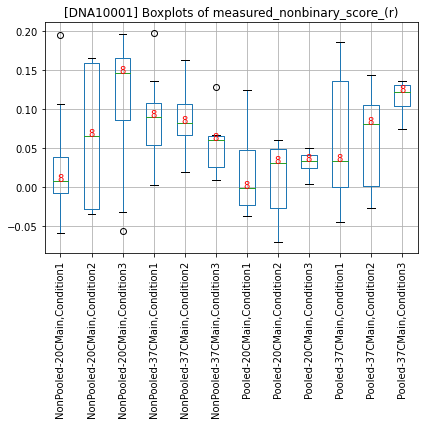

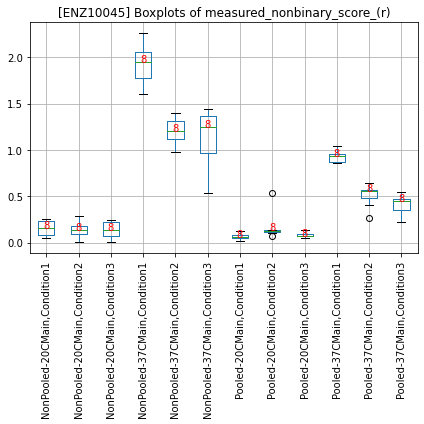

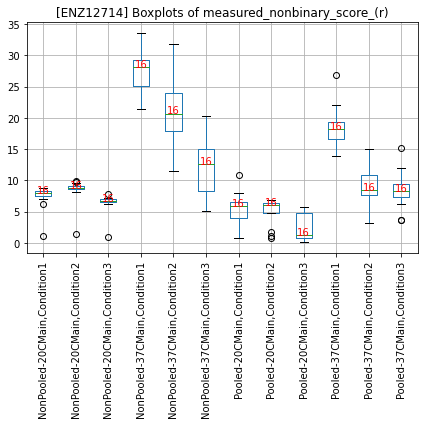

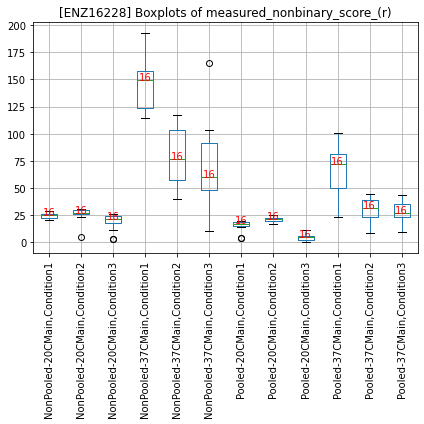

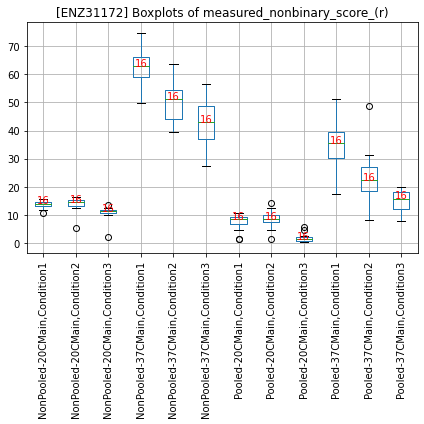

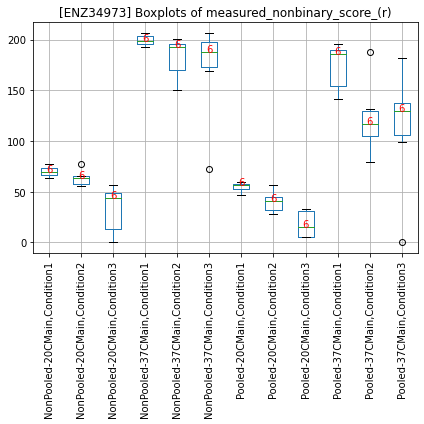

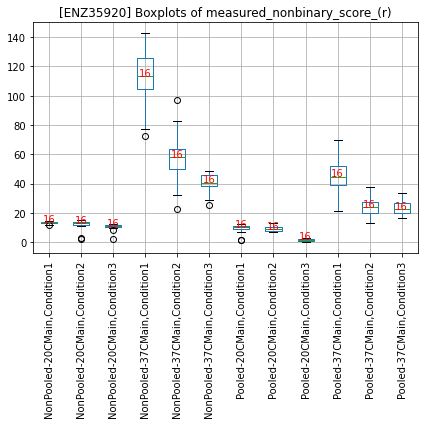

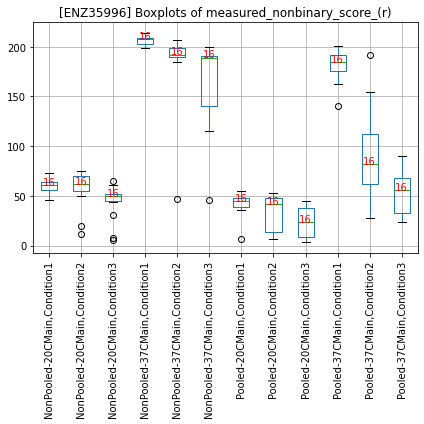

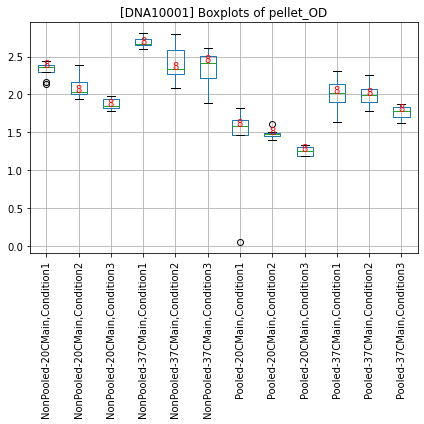

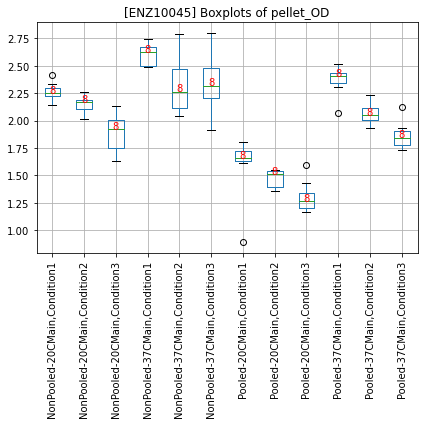

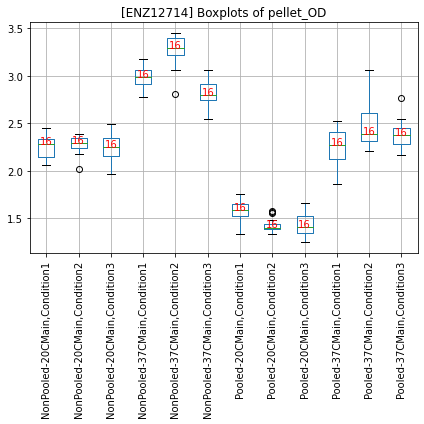

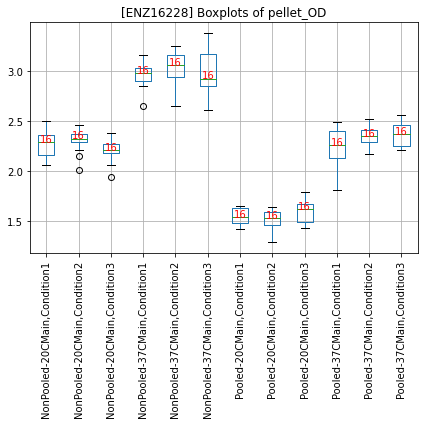

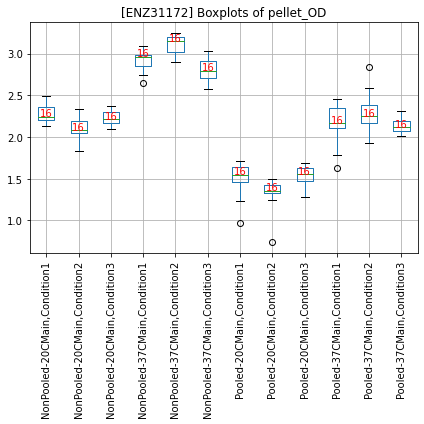

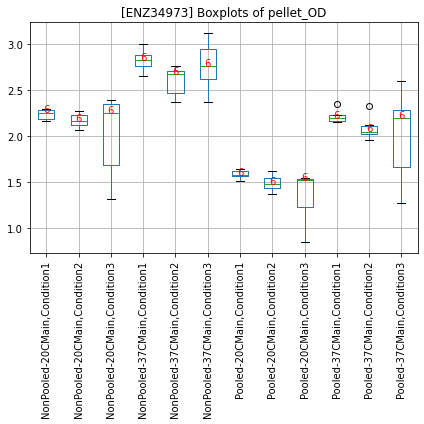

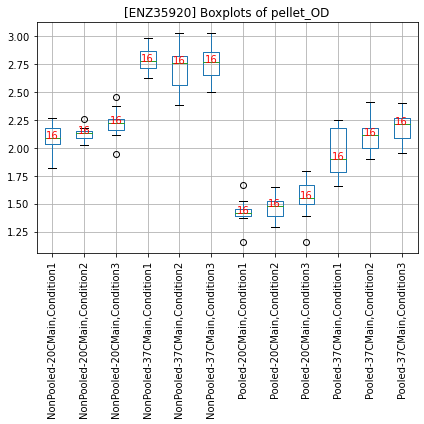

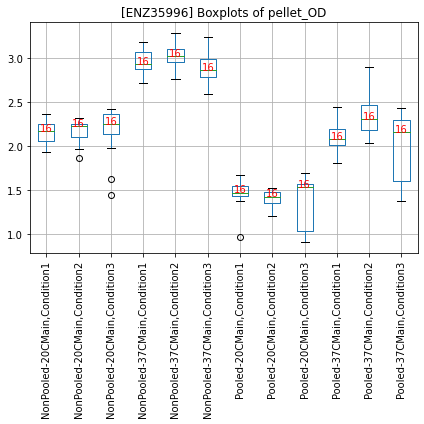

In [31]:
enz_list = sorted(list(set(df.enzyme_barcode)))
metric_list=['measured_nonbinary_score_(r)', 'pellet_OD'] # ['measured_nonbinary_score_(r)', 'measured_enantiomeric_excess_(+over-)']
metricname_list=['RacemicProduct', 'PelletOD']

# get boxplots, split by enzyme variant
for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    for enz in enz_list:
        print(enz)
        variant_reps = df.loc[df['enzyme_barcode']==enz]
        boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
            variant_reps, 
            metric_list=[metric],
            metricname_list=[metricname],
            groupby=['exp_condition'],
            fname_prefix=f'{enz}_'
        )

## Get boxplot across experiment conditions

Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-NONHITRATE_exp_condition.png to S3.
Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-MEAN_exp_condition.png to S3.
Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-MEDIAN_exp_condition.png to S3.
Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-STDEV_exp_condition.png to S3.
Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-CV_exp_condition.png to S3.
Saved VQ-IPTGexp/BOXPLOT_VAR-ONLY_RacemicProduct-FIOP_exp_condition.png to S3.


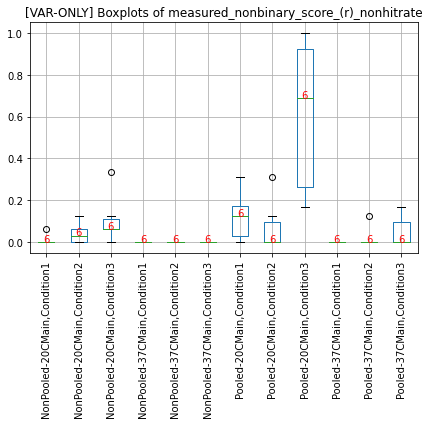

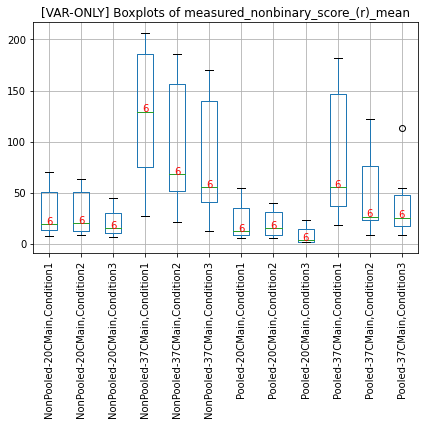

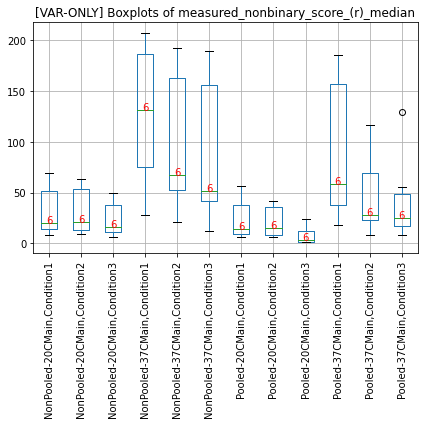

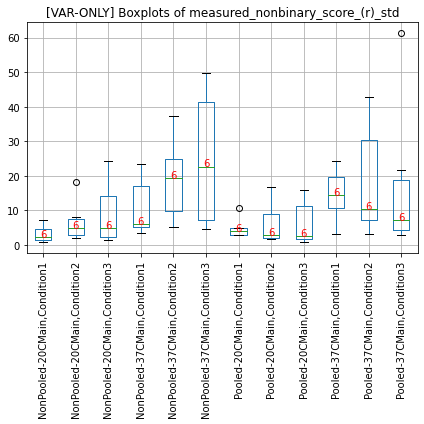

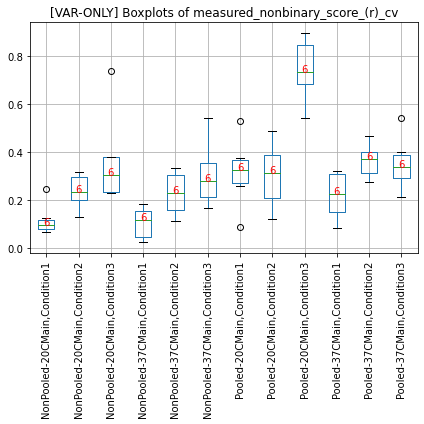

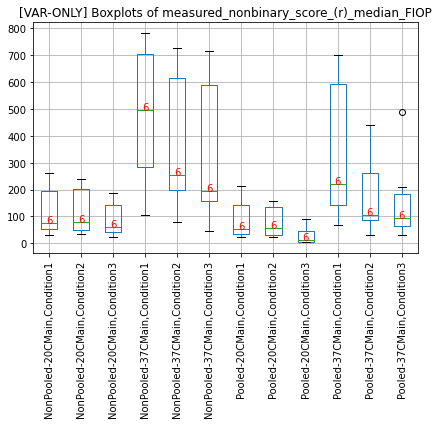

In [32]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
# REMOVE POSITIVE AND NEGATIVE CONTROLS
experiment_analytics_varonly = experiment_analytics.iloc[3:].copy()
experiment_analytics_varonly = experiment_analytics_varonly.loc[~experiment_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['exp_condition'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv', 'measured_nonbinary_score_(r)_median_FIOP']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV', 'RacemicProduct-FIOP']

# get boxplots, split by enzyme variant
# REMOVE NEGATIVE CONTROLS
experiment_analytics_noEV = experiment_analytics.iloc[3:].copy()
experiment_analytics_noEV = experiment_analytics_noEV.loc[~experiment_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        experiment_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['exp_condition'],
        fname_prefix='VAR-ONLY_'
    )

## Get boxplot across plates

In [ ]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
variant_plate_analytics_varonly = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_varonly = variant_analytics_varonly.loc[~variant_plate_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['lcms_plate_(r)'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV']

# get boxplots, split by enzyme variant
variant_plate_analytics_noEV = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_noEV = variant_plate_analytics_noEV.loc[~variant_plate_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['lcms_plate_(r)'],
        fname_prefix='VAR-ONLY_'
    )

## Get boxplot across experiment conditions AND plates

In [ ]:
metric_list=['measured_nonbinary_score_(r)_nonhitrate']
metricname_list=['RacemicProduct-NONHITRATE']

# get boxplots, split by enzyme variant
variant_plate_analytics_varonly = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_varonly = variant_plate_analytics_varonly.loc[~variant_plate_analytics_varonly.enzyme_barcode.isin(['DNA10001', 'ENZ10045'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_varonly, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['plate_expcondition'],
        fname_prefix='VAR-ONLY_'
    )
    
    
metric_list=['measured_nonbinary_score_(r)_mean', 'measured_nonbinary_score_(r)_median', 'measured_nonbinary_score_(r)_std', 'measured_nonbinary_score_(r)_cv']
metricname_list=['RacemicProduct-MEAN', 'RacemicProduct-MEDIAN', 'RacemicProduct-STDEV', 'RacemicProduct-CV']

# get boxplots, split by enzyme variant
variant_plate_analytics_noEV = variant_plate_analytics.iloc[3:].copy()
variant_plate_analytics_noEV = variant_plate_analytics_noEV.loc[~variant_plate_analytics_noEV.enzyme_barcode.isin(['DNA10001'])]

for i, (metric, metricname) in enumerate(zip(metric_list, metricname_list)):
    boxplot_activity_corr_list = analysis_pipeline.get_activity_correlation_boxplots(
        variant_plate_analytics_noEV, 
        metric_list=[metric],
        metricname_list=[metricname],
        groupby=['plate_expcondition'],
        fname_prefix='VAR-ONLY_'
    )

## Get scatter plots of Chiral metric vs. C18 metric

In [ ]:
# median values for each enzbarcode_expcondition, colorcoded by control type
analysis_pipeline.get_activity_correlation_scatterplots(
    experiment_analytics[3:], 
    xmetric_list=['measured_nonbinary_score_(r)_median'], 
    xmetricname_list=['RacemicProdConc-MEDIAN'], 
    ymetric='measured_enantiomeric_excess_(+over-)_median', 
    ymetricname='ChiralEE-MEDIAN', 
    groupby='ctrl_type_0', 
    table_suffix='', 
    showlegend=True
)

# invidual sample values, color coded by enzyme barcode
analysis_pipeline.get_activity_correlation_scatterplots(
    df, 
    xmetric_list=['measured_nonbinary_score_(r)'], 
    xmetricname_list=['RacemicProdConc'], 
    ymetric='measured_enantiomeric_excess_(+over-)', 
    ymetricname='ChiralEE', 
    groupby='enzyme_barcode', 
    table_suffix='', 
    showlegend=False
)

## Get scatter plots of C18 metric vs. PelletOD

Saved VQ-IPTGexp/SCATTERPLOT_RacemicProdConc-vs-PelletOD_enzyme_barcode.png to S3.


[<Figure size 360x360 with 1 Axes>]

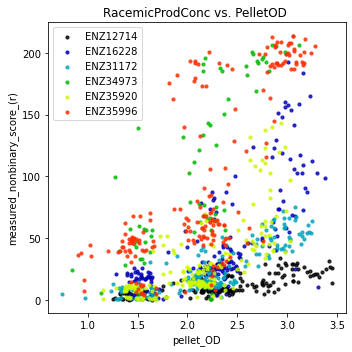

In [38]:
# invidual sample values, color coded by enzyme barcode
analysis_pipeline.get_activity_correlation_scatterplots(
    df, 
    xmetric_list=['pellet_OD'], 
    xmetricname_list=['PelletOD'], 
    ymetric='measured_nonbinary_score_(r)', 
    ymetricname='RacemicProdConc', 
    groupby='enzyme_barcode', 
    table_suffix='', 
    showlegend=True
)

# Get Analytics Dashboard

## Save dashboard contents to S3

In [24]:
# pickle analysis pipeline s3 folder
filename = f'{s3_subfolder}dashboard_contents.pkl'

# SAVE DASHBOARD CONTENTS
upload_to_s3(s3_bucket, filename, analysis_pipeline.dashboard_contents)  

# # LOAD MODEL
# dashboard_contents_unpickled = download_from_s3(s3_bucket, filename)
# print(dashboard_contents_unpickled)

## Initialize Analytics Pipeline object & get panel columns

In [ ]:
s3_subfolder = f'VQ-Retest5/' 
exp_workflow = ['WF10198']
table = 'combi_analytics_table' # 'lcms_detections' # 
analysis_pipeline = AnalysisPipeline(
    s3_subfolder=s3_subfolder, 
    neg_ctrltype='EV', 
    sort_by=None, 
    get_dashboard_panel=False,
    save_plots_to_s3=True
)

# fetch panel columns
panel_columns = analysis_pipeline.fetch_saved_panel_data()

In [ ]:
pn.template.FastListTemplate(
    site="Panel", 
    title=f"{s3_subfolder}Dev Analytics", 
    main=panel_columns, 
    main_max_width="1760px",
)#.servable();

# Manual Analysis

## Comparison to Phoenix Data

In [56]:
exp_workflow_phnx = ['WF10125','WF10128','WF10130','WF10132', 'WF10134', 'WF10136', 'WF10139', 'WF10144', 'WF10149', 'WF10157', 'WF10158', 'WF10163', 'WF10169', 'WF10173', 'WF10181']  # None # 
df_phnx = analysis_pipeline.load_data(table, exp_workflow=exp_workflow_phnx)
enz_list_varonly = [enz for enz in list(set(enz_list)) if enz not in ['DNA10001', 'ENZ10045']]
df_phnx_varonly = df_phnx.loc[df_phnx.enzyme_barcode.isin(enz_list_varonly)].reset_index(drop=True)

executing query: SELECT "id", "exp_workflow_barcode", "exp_workflow_name", "proj_barcode", "proj_name", "maldi_run", "lcms_C18_run", "lcms_chiral_run", "maldi_plate_(r)", "maldi_address_(r)", "lcms_plate_(r)", "lcms_address_(r)", "source_plate_(r)", "source_address_(r)", "maldi_plate_(+)", "maldi_address_(+)", "lcms_plate_(+)", "lcms_address_(+)", "source_plate_(+)", "source_address_(+)", "maldi_plate_(-)", "maldi_address_(-)", "lcms_plate_(-)", "lcms_address_(-)", "source_plate_(-)", "source_address_(-)", "ctrl_type", "exp_condition", "enzyme_barcode", "sequence", "mutations", "hamming", "reference_enzyme", "substrate_barcode_(r)", "substrate_barcode_(+)", "substrate_barcode_(-)", "substrate_smiles_(r)", "substrate_smiles_(+)", "substrate_smiles_(-)", "substrate_concentration_(r)", "substrate_concentration_(+)", "substrate_concentration_(-)", "predicted_binary_score_(r)", "predicted_nonbinary_score_(r)", "measured_nonbinary_score_(r)", "measured_nonbinary_sum_(r)", "measured_conversio

In [60]:
# combine Retest 5 and Phoenix dataset
df_all = pd.concat([df_phnx_varonly, df]).reset_index(drop=True)

# replace NaN exp_condition values with ''
df_all.loc[df_all.exp_condition.isnull(), 'exp_condition'] = ''

In [ ]:
from utils.visualization_utils import plot_boxplot

for enz in enz_list_varonly:
    print(enz)
    df_enz = df_all.loc[df_all.enzyme_barcode==enz]
    boxplot_list_enz = plot_boxplot(df_enz, ['measured_nonbinary_score_(r)'], groupby=['exp_workflow_barcode', 'exp_condition'], showplot=True, show_n=True)